In [1]:
#hide
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Rayleigh Weight Initializations
> Initializing the weights of complex-valued neural networks with Rayleigh distributions.  

- toc: true 
- badges: true
- comments: true
- categories: [complex neural networks, initializations, Rayleigh distribution]
- image: images/polar_plot.png

# Overview

This series of posts will build complex-valued neural networks in pytorch with an eye towards Radio Frequency (RF) applications.  
<br>
Part one introduces complex weight initializations with two pieces of information:
- **Magnitude**: the length of a vector
- **Phase**: where a vector is pointing  

The magnitudes are drawn from a Rayleigh distribution which is a natural representation of RF data.  
Next, we make sure the weights are good initial values by meeting a certain variance criteria.
We then put everything together by creating complex weights as pytorch tensors.  
<br>
To start, we give some backgroud on weight initializations and why they are important. 

# Background on initializations 

In order to successfully train deep neural networks, it is crucial to properly initialize their weights. While initializations are now taken for granted, they were one of the key pieces that made it possible to train deep networks in the first place. The main insights about what makes good weight initializations came from analyzing their variance. Specifically, how the variance of the weights affects network gradients during backpropagation.  
Great work by [He](https://arxiv.org/pdf/1502.01852.pdf) and [Glorot, Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) showed that the variance of weights should meet certain criteria if the gradients are to flow smoothly. Here, "smoothly" means that the gradients neither disappear (go to 0) nor explode (grow without bound) during training.  
The best known initializations are now the defaults in popular deep learning libraries such as TensorFlow or pytorch. However, complex-valued deep networks are newer and not as well established.

# Complex networks

Complex-valued networks have a long history, see Chapter 3 of [this work](https://www.cs.dartmouth.edu/~trdata/reports/TR2018-859.pdf) for a great historical recap. However, the first modern and complete take on deep complex neural nets is likely [Deep Complex Networks](https://arxiv.org/pdf/1705.09792.pdf) by Trabelsi et. al.  
This paper explored many fundamental building blocks for complex networks. It developed initializations, convolutions, activations, batch normalizations, then put them together into complex Residual Networks (ResNets).  
Despite this fantastic work the field stayed quiet at first. Yet there has been a recent spike in activity, more specifically with follow ups in: medical imaging, radio frequency (RF) signal processing, physical optical networks, and even some quantum networks!  
<br>
Next we take the first steps in making complex weights: creating their magnitudes.

# Rayleigh Distribution  



The typical introduction to Rayleigh distributions involves measuring wind speed through an area. For example, imagine setting up a sensor that records the speed of wind as it passes through. If we measure the wind speed in two directions, say North and East, then the magnitude of the wind's velocity will be Rayleigh distributed.  
More generally a Rayleigh distribution happens when two random variables are added. To be Rayleigh distributed, these random variables must be uncorrelated, normally distributed, zero mean, and share the same standard deviation.  
For our purposes, a more relevant example is listening to a radio signal. Imagine we tune a radio to an empty spectrum region where all we hear is noise. If we record the real and imaginary components of this RF stream, then their magnitudes will be Rayleigh distributed. In other words, the strength of RF noise follows a Rayleigh distribution.
<br>


Let's dive into the details. The equation below is for the Probability Density Function (PDF) of a Rayleigh distribution.

$$f(x,\sigma) = \frac{x}{\sigma^2}e^{-x^2/(2\sigma^2)}, \ \ x \geq 0$$

If this equation looks intimidating, we can code it up as a python function to make it much more accessible:

In [2]:
def rayleigh_pdf(x, sigma):
    "Finds Rayleigh PDF evaluated at `x`."
    p = (x / sigma**2) * np.exp(-x**2 / (2*sigma**2))
    return p

In the equation and code above sigma ($\sigma$) is the scale parameter. It is common in many probability distributions and usually controls how spread out or narrow a distribution is.

Let's start by setting $\sigma = 1$ to see the "basic" Rayleigh shape. We will then change sigma to see how it affects the distribution.

In [3]:
sigma = 1
# calculate PDF on 100 equally spaced points between 0 and 5
points = np.linspace(0, 5, 100)
ray_pdf = rayleigh_pdf(points, sigma)

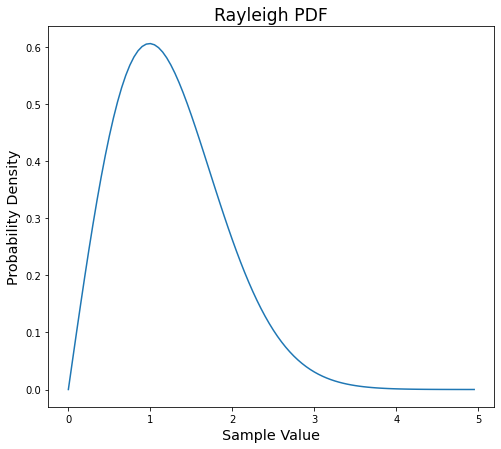

In [4]:
# plot the rayleigh pdf
fig,ax = plt.subplots(figsize=(8,7))
ax.plot(ray_pdf)
ax.set_xticklabels([-1] + list(range(len(ax.get_xticklabels()))))
ax.set_xlabel('Sample Value', fontsize='x-large')
ax.set_ylabel('Probability Density', fontsize='x-large')
ax.set_title('Rayleigh PDF', fontsize='xx-large');

As we mentioned the scale, $\sigma$, changes the width or narrowness of the distribution. Let's both halve and double sigma to see what happens.

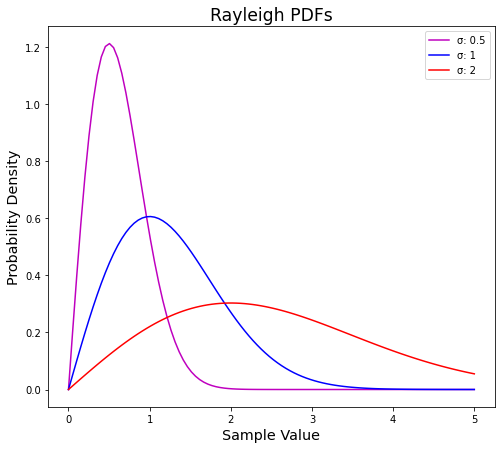

In [5]:
# setup plot
fig,ax = plt.subplots(figsize=(8,7))
ax.set_xlabel('Sample Value', fontsize='x-large')
ax.set_ylabel('Probability Density', fontsize='x-large')
ax.set_title('Rayleigh PDFs', fontsize='xx-large');
# plot sigmas in different colors
sigmas = [0.5, 1, 2]
colors = ['m', 'b', 'r']
for color,sig in zip(colors,sigmas):
    rpdf = rayleigh_pdf(points, sig)
    ax.plot(points, rpdf, c=color, label=f'σ: {sig}')
ax.set_xticklabels([-1] + list(range(len(ax.get_xticklabels()))))
ax.legend();

The blue line in plot above is the same PDF from the first plot where $\sigma = 1$.  
We can see how $\sigma = 0.5$ pulls the distribution up and to the left, while $\sigma = 2$ squishes it down and to the right.  
In other words, a smaller sigma makes our distribution narrower while a larger sigma makes it wider.

Plotting the theoretical Rayleigh PDF above only shows what the distribution *should* looks like. Now we need to actually generate the Rayleigh values.

# Generating Rayleigh samples

We will use the [RandomState](https://numpy.org/doc/stable/reference/random/legacy.html?highlight=numpy%20random%20randomstate#numpy.random.RandomState) class in the numpy library to generate Rayleigh samples. RandomState is a helpful class that can sample from just about every known distribution.

In [6]:
from numpy.random import RandomState
seed = 0

First we create the RandomState class with the chosen seed of $0$.

In [7]:
rand = RandomState(seed)

This class can directly sample from a Rayleigh distribution. We use the sampling function `RandomState.rayleigh` which accepts two parameters:
- `scale`: $\sigma$ with a default value of 1.
- `size`: the shape of the output array  
<br>

Let's start by drawing 1,000 Rayleigh samples with $\sigma = 1$. 

In [8]:
sigma = 1
shape = 1000 # one dimensional vector with 1000 samples

In [9]:
ray_vals = rand.rayleigh(scale=sigma, size=shape)

How to check if these samples are actually Rayleigh distributed?
We can refer back to our PDF plots at the beginning, which tell us how Rayleigh samples are "spread out" when they are created. The easiest way to check if these generated samples are spread out as expected is with a histogram.

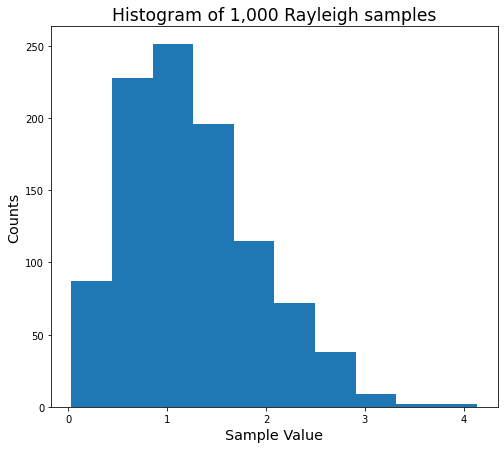

In [10]:
# plot histogram of 1000 drawn samples
plt.figure(figsize=(8,7))
plt.hist(ray_vals)
plt.xlabel('Sample Value', fontsize='x-large')
plt.ylabel('Counts', fontsize='x-large')
plt.title(f'Histogram of {shape:,} Rayleigh samples', fontsize='xx-large');

That looks pretty good!
As we generate more samples it should get even closer to the earlier PDF plots. Let's make sure this happens by now drawing 10,000 samples.

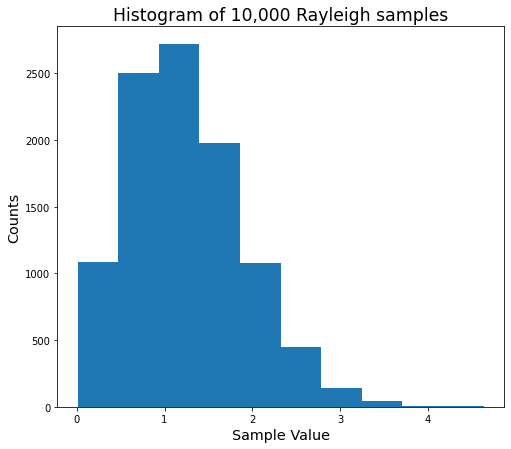

In [11]:
large_shape = 10000
many_ray_vals = rand.rayleigh(scale=sigma, size=large_shape)
plt.figure(figsize=(8,7))
plt.hist(many_ray_vals);
plt.xlabel('Sample Value', fontsize='x-large')
plt.ylabel('Counts', fontsize='x-large')
plt.title(f'Histogram of {large_shape:,} Rayleigh samples', fontsize='xx-large');

Looking even better. Let's compare this histogram against the theoretical Rayleigh PDF.  
Note that we pass `density=True` to the histogram function below to make it an approximate PDF.

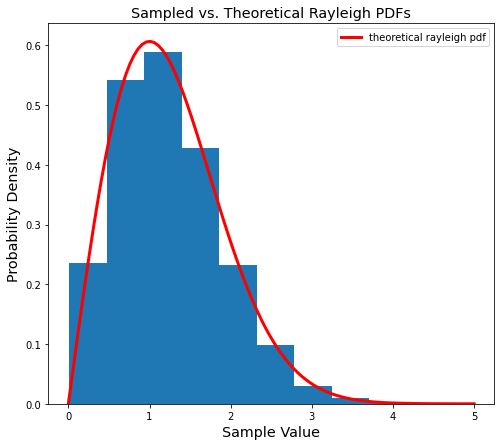

In [12]:
# compare theoretical vs. sampled Rayleigh PDFs
plt.figure(figsize=(8,7))
plt.hist(many_ray_vals, density=True) # makes the histogram sum to one, to mimic pdf
plt.plot(points, ray_pdf, c='r', label='theoretical rayleigh pdf', linewidth=3)
plt.title('Sampled vs. Theoretical Rayleigh PDFs', fontsize='x-large')
plt.xlabel('Sample Value', fontsize='x-large')
plt.ylabel('Probability Density', fontsize='x-large')
plt.legend();

# Adding phase information

With the Rayleigh values from above we now have the magnitude, or length, of the complex weights. But that is only one part of a complex number. We are still missing the phase, or angle, information. Phase gives the direction in the complex plane where a vector is pointing.  

For our purposes it is enough to use random angles. Why? Many processes such as speech, images, and RF modulations encode information in phase. We do not want to bias the networks to any of these particular phase setups. By adding random uniform phase, it is like starting with many vectors pointing out in all directions. Then, during training, the network learns how to best orient and scale the weights for its task. 

Adding this random uniform phase is straightforward. We pick uniform samples from $-\pi$ to $\pi$ radians which maps to a full loop of the unit circle. This can be done with the same `RandomState` class from before. 

In [13]:
# pick random directions along the unit circle
phase = rand.uniform(low=-np.pi, high=np.pi, size=ray_vals.shape)

The phase will split the Rayleigh magnitudes into real and imaginary components. We use the cosine of the phase for the real part, and the sine of the phase for the imaginary part. 

In [14]:
real = ray_vals * np.cos(phase)
imag = ray_vals * np.sin(phase)

Let's plot some of these values in the complex plane to see if we truly have randomly oriented vectors. We pick 100 random weights and expect to see vectors with different magnitudes spread out in all directions.

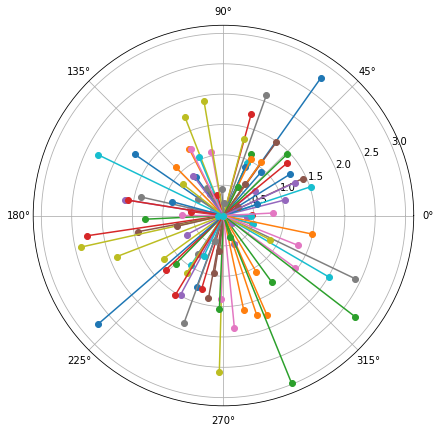

In [15]:
# plot a few complex weights
chosen_samples = range(100) # plot 100 random samples
plt.figure(figsize=(8,7))
for idx in chosen_samples:
    # index into phase and magnitude variables
    angle,mag = phase[idx],ray_vals[idx]
    plt.polar([0,angle],[0,mag], marker='o') # plot them starting from the origin

# Matching He and Glorot variance criteria

Even though we have real and imaginary components, they are not good initializations yet. The polar plot above gives some clues as to why (hint: look at the range of magnitudes between the vectors).
Recall from the background on initializations: the key insight was that the variance of the weights have to meet a certain criteria. If this criteria is met then the gradients can flow well during backpropagation.  

To get more specific, both the He and Glorot criteria are based on the incoming and outgoing connections in a network layer. The number of connections are typically called `fan_in` and `fan_out`, respectively.  

The He criteria says that the variance of weights $W$ should be: $$\text{Var}(W) = \frac{2}{\text{fan_in}}$$

The Glorot criteria says that the variance should be: $$\text{Var}(W) = \frac{2}{\text{fan_in + fan_out}}$$

Deep networks typically have hundreds or thousands of connections. In practice this means that the variance of the weights has to be very small. Now we can see why the values in the earlier polar plot are not good: their variance is clearly too large.

How can we generate Rayleigh samples that meet the He or Glorot variance criteria?
The [complex nets paper](https://arxiv.org/pdf/1705.09792.pdf) from earlier includes a nice derivation for the variance of a complex Rayleigh distribution: $$\text{Var}(W) = 2\sigma^{2}$$  
We can set the Rayleigh variance equal to the He and Glorot criteria and solve for sigma.

To meet the He criteria, sigma should be: $$\sigma_{\text{He}} = \frac{1}{\sqrt{\text{fan_in}}}$$ <br>

To meet the Glorot criteria, sigma should be: $$\sigma_{\text{Glorot}} = \frac{1}{\sqrt{\text{fan_in + fan_out}}}$$ <br>

Let's take a step back. In the earlier sections we used a flat vector of complex weights as an example. It's as if we took a single series of wind velocity or RF sample measurements.  
Since the He and Glorot criteria are defined specifically for network layers, we now switch to a simple one-layer network as an example. We aribtrarily choose a layer with 100 inputs and 50 outputs (`fan_in` = 100, `fan_out` = 50).

Plugging in these `fan_in` and `fan_out` numbers into the sigma equations gives:
$$\sigma_{\text{He}} = \frac{1}{10}$$

$$\sigma_{\text{Glorot}} = \frac{1}{5\sqrt{6}}$$

By plugging in these sigmas into the random sampler, it will draw Rayleigh values that match the chosen variance criteria. We can then add phase information in the same way as before.

# Putting it all together: complex pytorch initializer

Here is a short recap of the previous sections:
1. Drew a flat series of Rayleigh magnitudes.
2. Picked a random phase component, then split the magnitudes into real and imaginary parts.
3. Saw how to match the He and Glorot criteria with Rayleigh samples for a single network layer.  

To make the work above practical, we need to automatically generate complex weigths that:
- Match the He/Glorot variance criteria
- Are pytorch tensors
- Have the correct shape for the given network layer
<br>  

We can do this in a python function.

One quick word about calculating `fan_in` and `fan_out` values. We saw the feed-forward case with our single network layer. There the number of incoming connections was simply `fan_in` and the outgoing connections were `fan_out`.  
However, the convolutional case is slightly more complicated. A convolutional layer has input and output feature maps which are roughly analogous to input and output units in feed-forward layers. But we also have to factor in the kernel size. Pytorch has a nice [convenience function](https://pytorch.org/docs/stable/_modules/torch/nn/init.html#_calculate_fan_in_and_fan_out) to help.

We can now package all of the code above, with some refactoring, into a function that automatically generates complex Rayleigh weights given an input pytorch module.

In [16]:
import torch

def get_complex_inits(module, seed=None, criterion='he'):
    "Creates real and imaginary Rayleigh weights for initialization."
    # create random number generator
    rand = RandomState(seed if seed is None else torch.initial_seed())
    # get weight shape
    weight_size = module.weight.size()
    # find number of input and output connection
    fan_in,fan_out = torch.nn.init._calculate_fan_in_and_fan_out(module.weight)
    # find sigma to meet chosen variance criteria
    assert criterion in ('he','glorot')
    factor = fan_in if criterion == 'he' else fan_in + fan_out
    sigma = 1. / np.sqrt(factor)
    # draw rayleigh magnitude samples
    magnitude = rand.rayleigh(scale=sigma, size=weight_size)
    # draw uniform angle samples
    phase = rand.uniform(low=-np.pi, high=np.pi, size=magnitude.shape)
    # split magnitudes into real and imaginary components
    real = magnitude * np.cos(phase)
    imag = magnitude * np.sin(phase)
    # turn into float tensors and return
    real,imag = map(torch.from_numpy, [real,imag])
    return real,imag
    

## Testing on a `nn.Linear` module

We can test this on a single layer using pytorch's `nn.Linear` module.

In [17]:
m = torch.nn.Linear(100, 50)
real,imag = get_complex_inits(m)

Let's check if the weights are correctly distributed. Going back to our Rayleigh introduction, it is the magnitude that should be Rayleigh distributed.

In [18]:
# grab magnitude as flat vector of numpy samples
magnitude = torch.sqrt(real**2 + imag**2).numpy().reshape(-1)

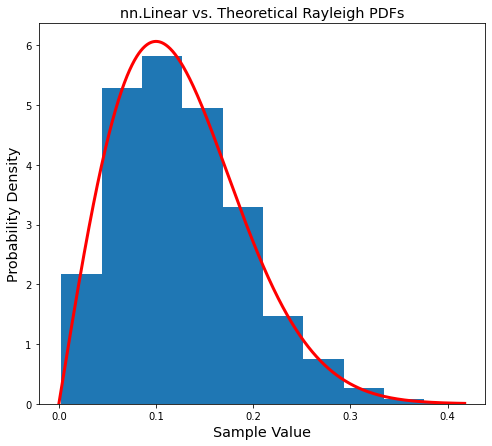

In [19]:
# pick points that cover sample range to compare with theoretical rayleigh pdf
points = np.linspace(0, magnitude.max(), 1000)
ray_pdf = rayleigh_pdf(points, sigma=1./np.sqrt(100))

# plot histogram of magnitudes vs. theoretical pdf
plt.figure(figsize=(8,7))
plt.title('nn.Linear vs. Theoretical Rayleigh PDFs', fontsize='x-large')
plt.xlabel('Sample Value', fontsize='x-large')
plt.ylabel('Probability Density', fontsize='x-large')
plt.hist(magnitude, density=True)
plt.plot(points, ray_pdf, c='r', linewidth=3);

Success!

## Testing on a `nn.Conv2d` module

What about a convolutional layer? Our main concern here is that both the tensor shape and `fan_in`/`fan_out` are handled correctly.

In [20]:
# make conv layer with 100 input features, 50 output features, and (3x3) kernel
m = torch.nn.Conv2d(100, 50, 3)
real,imag = get_complex_inits(m) # get the initial complex weights

# make sure the shape of weights is ok
print(f'Shapes of real and imaginary convolution tensors: {real.shape}, {imag.shape}')

Shapes of real and imaginary convolution tensors: torch.Size([50, 100, 3, 3]), torch.Size([50, 100, 3, 3])


Let's check if they are still Rayleigh distributed in the same way as before.

In [21]:
# grab magnitude as flat vector of numpy samples
magnitude = torch.sqrt(real**2 + imag**2).numpy().reshape(-1)

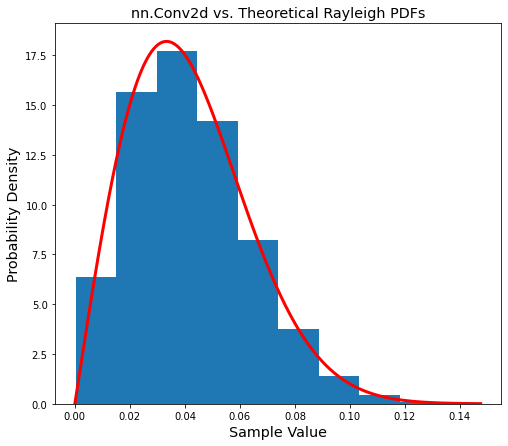

In [22]:
# pick points that cover sample range to compare with theoretical rayleigh pdf
points = np.linspace(0, magnitude.max(), 1000)
# we need fan_in for the more complicated conv case
fan_in,fan_out = torch.nn.init._calculate_fan_in_and_fan_out(m.weight)
ray_pdf = rayleigh_pdf(points, sigma=1./np.sqrt(fan_in))

# plot histogram of magnitudes vs. theoretical pdf
plt.figure(figsize=(8,7))
plt.title('nn.Conv2d vs. Theoretical Rayleigh PDFs', fontsize='x-large')
plt.xlabel('Sample Value', fontsize='x-large')
plt.ylabel('Probability Density', fontsize='x-large')
plt.hist(magnitude, density=True)
plt.plot(points, ray_pdf, c='r', linewidth=3);

# Conclusion

In this post we created Rayleigh initializations for complex-valued neural networks. We started with an overview of the Rayleigh distribution. We then used this distribution to generate the magnitudes of complex weights. Next we added some phase information to randomly orient the vectors. After that, we made sure the weights matched a certain variance criteria to be good initializations.  
Lastly we put all that work together into a python function that returns pytorch tensors.

Part two will look at another type of complex initialization based on (semi) unitary matrixes. After that we will proceed to build complex convolutions and actvations.